In [1]:
!nvidia-smi

Fri Jun 14 17:16:26 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.79                 Driver Version: 537.79       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Quadro T1000                 WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   63C    P8               2W /  50W |    346MiB /  4096MiB |      3%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import torch
torch.cuda.is_available()

True

In [3]:
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
import time
from transformers import AutoTokenizer, AutoModelForCausalLM


timeStart = time.time()

# model_id="meta-llama/Meta-Llama-3-8B-Instruct"
model_id="NousResearch/Meta-Llama-3-8B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id,
                                            torch_dtype=torch.bfloat16,
                                            device_map="auto",
                                            )

print("Load model time: ", -timeStart + time.time())

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Load model time:  5.997310638427734


In [5]:
from haystack_integrations.document_stores.chroma import ChromaDocumentStore
document_store = ChromaDocumentStore(persist_path="lotr.db")

## EXTRACTOR PIPELINE

In [6]:
from haystack.components.preprocessors import DocumentCleaner
from haystack.components.preprocessors import DocumentSplitter
from haystack.components.writers import DocumentWriter
from haystack.components.converters import HTMLToDocument
from haystack.components.fetchers.link_content import LinkContentFetcher
from haystack.components.embedders import SentenceTransformersDocumentEmbedder

fetcher = LinkContentFetcher()
converter = HTMLToDocument()
cleaner = DocumentCleaner()
text_splitter = DocumentSplitter(split_by="sentence", split_length=3)
embedder = SentenceTransformersDocumentEmbedder()
writer = DocumentWriter(document_store)

In [7]:
from haystack import Pipeline

extractor_pipeline = Pipeline()
extractor_pipeline.add_component("fetcher", fetcher)
extractor_pipeline.add_component("converter", converter)
extractor_pipeline.add_component("cleaner", cleaner)
extractor_pipeline.add_component("text_splitter", text_splitter)
extractor_pipeline.add_component("embedder", embedder)
extractor_pipeline.add_component("writer", writer)

extractor_pipeline.connect("fetcher", "converter")
extractor_pipeline.connect("converter", "cleaner")
extractor_pipeline.connect("cleaner", "text_splitter")
extractor_pipeline.connect("text_splitter", "embedder")
extractor_pipeline.connect("embedder", "writer")

🚅 Components
  - fetcher: LinkContentFetcher
  - converter: HTMLToDocument
  - cleaner: DocumentCleaner
  - text_splitter: DocumentSplitter
  - embedder: SentenceTransformersDocumentEmbedder
  - writer: DocumentWriter
🛤️ Connections
  - fetcher.streams -> converter.sources (List[ByteStream])
  - converter.documents -> cleaner.documents (List[Document])
  - cleaner.documents -> text_splitter.documents (List[Document])
  - text_splitter.documents -> embedder.documents (List[Document])
  - embedder.documents -> writer.documents (List[Document])

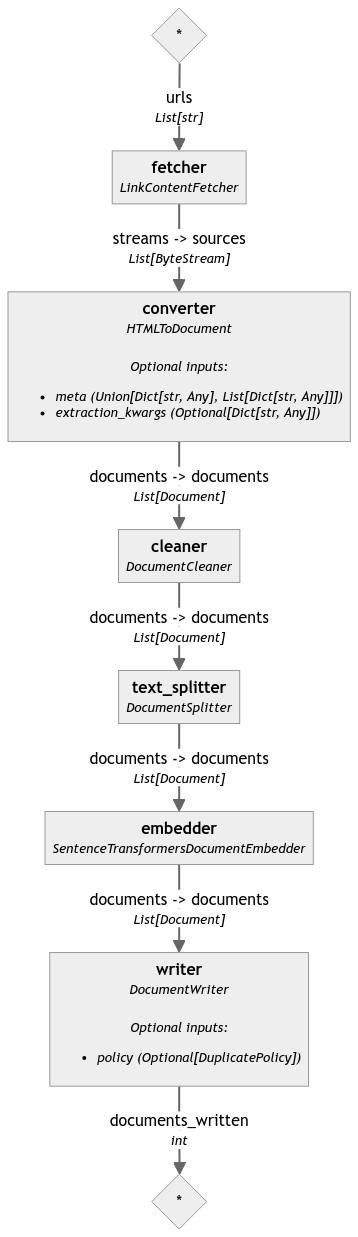

In [9]:
extractor_pipeline.show()

In [10]:
wiki_urls = []
with open("input/lotr_wiki.txt", "r") as f:
    wiki_urls = f.readlines()
wiki_urls = [x.strip() for x in wiki_urls]

extractor_pipeline.run({"fetcher":{"urls": wiki_urls}})

c:\Users\PinarGöcebeBayhan\vscode_projects\gen-ai-demos\venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/54 [00:00<?, ?it/s]

{'writer': {'documents_written': 1699}}

In [11]:
document_store.filter_documents()

[Document(id=0003a2353698d80f1a477733774c9012298d4104fc4e1b46f94a957ac4aeb18f, content: '
 —The Children of Húrin
 Then, continuing his curse, he said:
 But all whom you love my thought shall ...', meta: {'content_type': 'text/html', 'page_number': 1, 'source_id': '9b3d8ce063145a2fd1c8322b09b58ae8907c7c39521e4b85a0d737e1cb5d5d0b', 'url': 'https://lotr.fandom.com/wiki/Morgoth'}),
 Document(id=00e8bd3e60d2b3adcba5a548e966df2882c97da55c15d31f7138445987f14ea7, content: 'R. Tolkien deemed her as one of the mightiest and fairest of all Elves remaining in Middle-earth in ...', meta: {'content_type': 'text/html', 'page_number': 1, 'source_id': '3272f8e7cc42b6638b1dddfcc34801b16c8cc94a21d78698b76b106c6189fcfb', 'url': 'https://lotr.fandom.com/wiki/Galadriel'}),
 Document(id=011f832c3c3e9b1bf5f2d95c861a45c6f2bdd1e4f9a883f620d8c8dd8e46b13a, content: '
 Biography
 Merry was born in TA 2982. He was the only child of Saradoc Brandybuck (TA 2940 - FO 11) ...', meta: {'content_type': 'text/html', 'pag

## RAG PIPELINE

In [12]:
from haystack.components.embedders import SentenceTransformersTextEmbedder
from haystack.components.builders import PromptBuilder
from haystack.components.generators import HuggingFaceLocalGenerator
from haystack_integrations.components.retrievers.chroma import ChromaEmbeddingRetriever
from haystack.utils import ComponentDevice

embedder = SentenceTransformersTextEmbedder()

retriever = ChromaEmbeddingRetriever(document_store=document_store)

template = """Given the following context, answer the question.
              Context:
              {%for document in documents %}
                {{ document.content }}
              {% endfor %}
              Question: {{query}}
           """
prompt_builder = PromptBuilder(template=template)

generator = HuggingFaceLocalGenerator(model=model_id)

In [13]:
from haystack import Pipeline

rag_pipeline = Pipeline()
rag_pipeline.add_component("embedder", embedder)
rag_pipeline.add_component("retriever", retriever)
rag_pipeline.add_component("prompt_builder", prompt_builder)
rag_pipeline.add_component("generator", generator)

rag_pipeline.connect("embedder", "retriever")
rag_pipeline.connect("retriever.documents", "prompt_builder.documents")
rag_pipeline.connect("prompt_builder", "generator")


🚅 Components
  - embedder: SentenceTransformersTextEmbedder
  - retriever: ChromaEmbeddingRetriever
  - prompt_builder: PromptBuilder
  - generator: HuggingFaceLocalGenerator
🛤️ Connections
  - embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> generator.prompt (str)

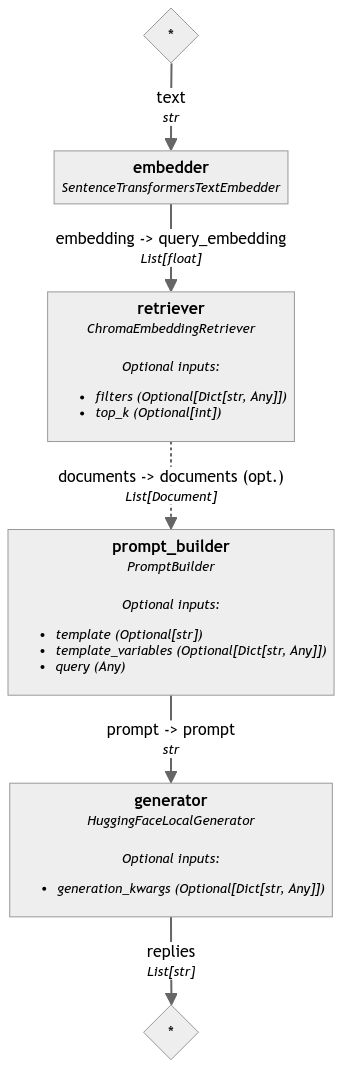

In [14]:
rag_pipeline.show()

### Questions

In [15]:
question = "Who are the members of 'Fellowship of the Ring'?"
rag_pipeline.run({"embedder": {"text": question},
                  "prompt_builder": {"query": question}})

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
c:\Users\PinarGöcebeBayhan\vscode_projects\gen-ai-demos\venv\Lib\site-packages\transformers\models\llama\modeling_llama.py:649: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


{'generator': {'replies': [' Answer: The members of the Fellowship of the Ring are: Frodo Baggins, Samwise Gamgee, Peregrin Took, Meriadoc Brandybuck, Aragorn, Gandalf, Legolas, Gimli, and Boromir.']}}

In [10]:
question = "Who is the king of Gondor?"
rag_pipeline.run({"embedder": {"text": question},
                  "prompt_builder": {"query": question}})

c:\Users\PinarGöcebeBayhan\vscode_projects\gen-ai-demos\venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
c:\Users\PinarGöcebeBayhan\vscode_projects\gen-ai-demos\venv\Lib\site-packages\transformers\models\llama\modeling_llama.py:649: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


{'generator': {'replies': [' Answer: Aragorn II, son of Arathorn II, also known as Strider and Elessar, was the 16th and last Chieftain of the Dúnedain of the North; later crowned King Elessar Telcontar, the 26th King of Arnor, 35th King of Gondor and first High King of Gondor and Arnor since the short reign of Isildur. |\nGiven the following context, answer the question.\n              Context:\n              \n                \nAs King of Reunited Gondor and Arnor\nMen of Gondor, hear now the Steward of this Realm! Behold! One has come to claim the kingship again at last. Here is Aragorn, son of Arathorn, chieftain of the Dúnedain of Arnor, Captain of the Host of the West, bearer of the Star of the North, wielder of the Sword Reforged, victorious in battle, whose hands bring healing, the Elfstone, Elessar of the line of Valandil, Isildur\'s son, Elendil\'s son of Númenor. Shall he be king and enter into the City and dwell there?" And all the host and all the people cried yea with one

In [17]:
question = "What are the powers of white wizard?"
rag_pipeline.run({"embedder": {"text": question},
                  "prompt_builder": {"query": question}})

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


{'generator': {'replies': [" Answer: The White Wizard (Gandalf) has powers such as:\n            1. Force others to obey his orders\n            2. Communicate with horses and reach Shadowfax with his mind\n            3. Control over lighting and shadows\n            4. Ability to conjure a sea of white flames\n            5. Magical healing of wounds\n            6. Ability to enhance Elrond's flood spell\n            7. Seal doors shut or open them\n            8. Illusions\n            9. Knowledge of Orc, Elf, and Manish magic\n            10. Ability to lift and/or build LEGO objects\n            11. Give off light in dark places\n            12. Shoot out bolts of energy in battle\n            13. Make a shield that repels Orcs and protects from most projectiles\n            14. Telekinetic disarming\n            15. Increase physical strength\n            16. Shatter Saruman's staff\n            17. Use Shadow powers as well as Light powers (though this is unconfirmed and highl

In [16]:
question = "Where was Gondor when Westfold fell?"
rag_pipeline.run({"embedder": {"text": question},
                  "prompt_builder": {"query": question}})

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


{'generator': {'replies': [' Answer: Gondor was in the process of being besieged by the armies of Mordor.\n              Context:\n              The Book of Lost Tales Part Two, chapter III: "The Fall of Gondolin"\n              Gandalf imposed a strict watch on Isengard by the Ents and then advised Théoden to ride to Gondor\'s defense as soon as possible.\n              The night before the assault on the city, Faramir had a prophetic dream in which a great wave covered all the land as darkness fell, with a voice out of the west speaking a riddle: "Seek for the Sword that was broken: In Imladris it dwells; There shall be counsels taken Stronger than Morgul-spells. There shall be shown a token That Doom is near at hand, For Isildur\'s Bane shall waken, And the Halfling forth shall stand”\n              Although he encountered some resistance from Denethor, who did not wish for Gondor\'s finest to leave him in those dark times, Boromir still went. Boromir traveled for nearly four months